<a href="https://colab.research.google.com/github/ProgramasParaFisicaDeParticulas/DelPerceptonAlQubit/blob/main/regresi%C3%B3n_logistica_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Librerías y funciones auxiliares

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [ ]:

color_magenta = '#E91E63'    # Magenta principal
color_azul = '#2196F3'       # Azul medio
color_cyan = '#00BCD4'       # Cyan/turquesa
color_violeta = "#A816C2"    # Violeta
color_verde = '#4CAF50'      # Verde complementario

_malla_calculada = False
_W1_global = None
_W2_global = None
_J_global = None

def calcular_malla_costo_una_vez(X, y_true, costo_bce):
    """
    Calcula la malla de costo una sola vez con límites fijos
    """
    global _malla_calculada, _W1_global, _W2_global, _J_global

    if not _malla_calculada:
        w1_range = np.linspace(-1, 10, 50)
        w2_range = np.linspace(-2, 10, 50)
        _W1_global, _W2_global = np.meshgrid(w1_range, w2_range)

        _J_global = np.zeros_like(_W1_global)
        for i in range(len(w1_range)):
            for j in range(len(w2_range)):
                _J_global[j, i] = costo_bce(X, y_true, _W1_global[j, i], _W2_global[j, i])

        _malla_calculada = True

def visualizar_funcion_costo_logistica(X, y_true, costo_bce, hipotesis, w1_actual, w2_actual, costos, w1_hist, w2_hist, titulo_punto="Punto actual"):
    """
    Visualiza la función de costo BCE y convergencia con un punto específico marcado

    Parámetros:
    X: datos de entrada
    y_true: valores reales (0 o 1)
    costo_bce: función de costo binary cross entropy
    hipotesis: función hipótesis logística
    w1_actual: valor actual del peso w1
    w2_actual: valor actual del peso w2
    costos: historial de costos
    w1_hist: historial de w1
    w2_hist: historial de w2
    titulo_punto: etiqueta para el punto marcado
    """
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.gridspec as gridspec

    calcular_malla_costo_una_vez(X, y_true, costo_bce)

    global _W1_global, _W2_global, _J_global
    W1, W2, J = _W1_global, _W2_global, _J_global

    clear_output(True)
    fig = plt.figure(figsize=(20, 12))
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[:, 0:2], projection='3d', computed_zorder=False)
    surf = ax1.plot_surface(W1, W2, J, cmap='cool', alpha=0.8, zorder=1)
    ax1.set_xlabel('w1 (peso X1)', fontsize=12, color='#333333')
    ax1.set_ylabel('w2 (peso X2)', fontsize=12, color='#333333')
    ax1.set_zlabel('Costo J (BCE)', fontsize=12, color='#333333')
    ax1.set_title('Función de Costo BCE (3D)', fontsize=14, fontweight='bold', color='#333333')

    ax1.view_init(elev=40, azim=45)

    costo_actual = costo_bce(X, y_true, w1_actual, w2_actual)
    elevacion = (J.max() - J.min()) * 0.05
    z_punto = costo_actual + elevacion

    ax1.scatter([w1_actual], [w2_actual], [z_punto],
                color=color_magenta, s=150, label=titulo_punto,
                edgecolors='white', linewidth=2, alpha=0.9, zorder=10)

    ax1.legend(fontsize=12)

    ax2 = fig.add_subplot(gs[0:2, 2:4])

    clase_0 = y_true == 0
    clase_1 = y_true == 1

    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = hipotesis(mesh_points, w1_actual, w2_actual)
    Z = Z.reshape(xx.shape)

    contour_fill = ax2.contourf(xx, yy, Z, levels=20, cmap='PuRd', alpha=0.6)
    ax2.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

    ax2.scatter(X[clase_0, 0], X[clase_0, 1], color=color_magenta, alpha=0.8,
               label='Clase 0', s=50, edgecolors='white', linewidth=0.5)
    ax2.scatter(X[clase_1, 0], X[clase_1, 1], color=color_azul, alpha=0.8,
               label='Clase 1', s=50, edgecolors='white', linewidth=0.5)

    ax2.set_xlabel('X1', fontsize=12, color='#333333')
    ax2.set_ylabel('X2', fontsize=12, color='#333333')
    ax2.set_title('Mapa de Probabilidades', fontsize=14, fontweight='bold', color='#333333')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, color='#CCCCCC')
    ax2.set_facecolor('#FAFAFA')

    ax3 = fig.add_subplot(gs[2, 2])
    if costos is not None:
        ax3.plot(costos, color=color_violeta, linewidth=3, alpha=0.8)
        ax3.set_xlabel('Iteraciones', color='#333333')
        ax3.set_ylabel('Costo J (BCE)', color='#333333')
        ax3.set_title('Convergencia del Costo', color='#333333', fontweight='bold')
        ax3.grid(True, alpha=0.3, color='#CCCCCC')
        ax3.set_facecolor('#FAFAFA')
    else:
        ax3.text(0.5, 0.5, 'Ejecutar entrenamiento\\npara ver convergencia',
                ha='center', va='center', transform=ax3.transAxes, color='#666666')
        ax3.set_title('Convergencia del Costo', color='#333333', fontweight='bold')

    ax4 = fig.add_subplot(gs[2, 3])
    contour = ax4.contourf(W1, W2, J, levels=50, cmap='cool', alpha=0.6)
    contour_lines = ax4.contour(W1, W2, J, levels=15, alpha=0.3, colors='white', linewidths=0.5)
    ax4.clabel(contour_lines, inline=True, fontsize=7, colors='white')

    if w1_hist is not None and w2_hist is not None:
        ax4.plot(w1_hist, w2_hist, color=color_magenta, linewidth=3, alpha=0.8, label='Trayectoria')
        ax4.scatter([w1_hist[0]], [w2_hist[0]], color=color_verde, s=100, marker='o',
                   label='Inicio', edgecolors='white', linewidth=2)
        ax4.scatter([w1_actual], [w2_actual], color=color_magenta, s=100, marker='s',
                   label='Actual', edgecolors='white', linewidth=2)
    else:
        ax4.scatter([w1_actual], [w2_actual], color=color_magenta, s=100, marker='x', label=titulo_punto)

    ax4.set_xlabel('w1', color='#333333')
    ax4.set_ylabel('w2', color='#333333')
    ax4.set_title('Trayectoria GD', color='#333333', fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3, color='#CCCCCC')
    ax4.set_facecolor('#FAFAFA')

    fig.patch.set_facecolor('white')

    plt.show()

    print(f"Costo en w1={w1_actual:.4f}, w2={w2_actual:.4f}: {costo_bce(X, y_true, w1_actual, w2_actual):.4f}")

# Regresión Logística: Ejemplo Didáctico

## Objetivos de este Notebook

Este notebook presenta una implementación didáctica de **regresión logística** desde cero, diseñada para comprender los conceptos fundamentales de clasificación binaria. Los objetivos son:

1. **Generar datos sintéticos** con dos clases linealmente separables
2. **Implementar la función hipótesis sigmoide** con dos parámetros entrenables ($w_1$, $w_2$)
3. **Definir la función de costo BCE** (Binary Cross Entropy)
4. **Visualizar la función de costo** en 3D para observar su forma
5. **Implementar el algoritmo de gradiente descendente** para optimización
6. **Mostrar la convergencia** y la frontera de decisión durante el entrenamiento

## Conceptos Clave

### Regresión Logística
La regresión logística es un algoritmo de aprendizaje supervisado para clasificación binaria que modela la probabilidad de que una muestra pertenezca a una clase específica.

### Función Hipótesis Sigmoide
Nuestra función hipótesis simplificada es:
$$f(x) = \sigma(w_1 \cdot x_1 + w_2 \cdot x_2) = \frac{1}{1 + e^{-(w_1 x_1 + w_2 x_2)}}$$

Donde:
- $w_1, w_2$: pesos para las características $x_1, x_2$
- $\sigma$: función sigmoide que mapea cualquier valor real a (0,1)
- **Sin intercepto**: La frontera de decisión pasa por el origen

### Función de Costo BCE
Para medir qué tan bien nuestro modelo clasifica, usamos:
$$J(w_1, w_2) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(f(x^{(i)})) + (1-y^{(i)}) \log(1-f(x^{(i)})) \right]$$

Donde:
- $m$ = número de ejemplos de entrenamiento
- $f(x^{(i)})$ = probabilidad predicha para el ejemplo $i$
- $y^{(i)} \in \{0,1\}$ = etiqueta real del ejemplo $i$

---

## 1. Generación de Datos Sintéticos para Clasificación

En esta sección creamos datos artificiales de dos clases que son linealmente separables. Esto nos permite:

- **Controlar la complejidad**: Conocemos que las clases son separables
- **Validar nuestro algoritmo**: Podemos verificar si encuentra la frontera correcta
- **Visualizar el proceso**: Es fácil interpretar los resultados en 2D

### ¿Qué hace el código?

1. **`np.random.seed(42)`**: Fija la semilla para reproducibilidad
2. **Generación de clases**: Creamos dos grupos de puntos bien separados
3. **Clase 0**: Puntos en la región inferior-izquierda
4. **Clase 1**: Puntos en la región superior-derecha
5. **Etiquetas**: 0 para la primera clase, 1 para la segunda

### Interpretación del Gráfico
- **Puntos azules**: Clase 0 (etiqueta = 0)
- **Puntos magenta**: Clase 1 (etiqueta = 1)
- **Separabilidad**: Se puede trazar una línea recta que separe ambas clases

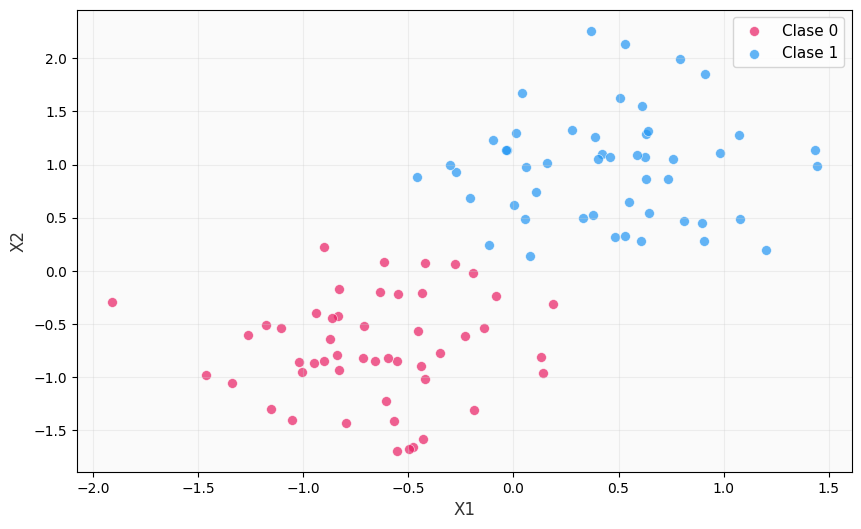

Datos generados: 100 ejemplos
Clase 0: 50 ejemplos
Clase 1: 50 ejemplos


In [ ]:
np.random.seed(42)
m = 100

m0 = m // 2
X0 = np.random.randn(m0, 2) * 0.5 + np.array([[-0.6, -0.7]])
y0 = np.zeros(m0)

m1 = m - m0
X1 = np.random.randn(m1, 2) * 0.5 + np.array([[0.5, 0.9]])
y1 = np.ones(m1)

X = np.vstack([X0, X1])
y_true = np.concatenate([y0, y1])

plt.figure(figsize=(10, 6))
clase_0 = y_true == 0
clase_1 = y_true == 1

plt.scatter(X[clase_0, 0], X[clase_0, 1], alpha=0.7, color=color_magenta,
           label='Clase 0', s=50, edgecolors='white', linewidth=0.5)
plt.scatter(X[clase_1, 0], X[clase_1, 1], alpha=0.7, color=color_azul,
           label='Clase 1', s=50, edgecolors='white', linewidth=0.5)

plt.xlabel('X1', fontsize=12, color='#333333')
plt.ylabel('X2', fontsize=12, color='#333333')
plt.grid(True, alpha=0.3, color='#CCCCCC')
plt.legend(fontsize=11)
plt.gca().set_facecolor('#FAFAFA')
plt.gcf().patch.set_facecolor('white')
plt.show()

print(f"Datos generados: {m} ejemplos")
print(f"Clase 0: {np.sum(y_true == 0)} ejemplos")
print(f"Clase 1: {np.sum(y_true == 1)} ejemplos")

## 2. Función Hipótesis Sigmoide y Función de Costo BCE

### Función Hipótesis Sigmoide
La función hipótesis en regresión logística usa la función sigmoide para mapear cualquier valor real a una probabilidad entre 0 y 1:

$$f(x) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

Donde $z = w_1 x_1 + w_2 x_2$ es la combinación lineal de las características **sin intercepto**.

- **Entrada**: Un vector $x = [x_1, x_2]$ (características)
- **Salida**: Una probabilidad $f(x) \in (0,1)$ de pertenecer a la clase 1
- **Parámetros**: $w_1, w_2$ (pesos para cada característica)
- **Frontera de decisión**: La línea pasa por el origen

### Función de Costo BCE (Binary Cross Entropy)
Para medir qué tan "buenas" son nuestras predicciones de probabilidad, usamos:

$$J(w_1, w_2) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(f(x^{(i)})) + (1-y^{(i)}) \log(1-f(x^{(i)})) \right]$$

#### ¿Por qué BCE?
- **Penaliza predicciones incorrectas**: Si $y=1$ y $f(x) \to 0$, el costo $\to \infty$
- **Recompensa predicciones correctas**: Si $y=1$ y $f(x) \to 1$, el costo $\to 0$
- **Función convexa**: Garantiza un único mínimo global
- **Diferenciable**: Permite usar gradiente descendente

#### Interpretación del Código
- **`costo_inicial`**: Con parámetros iniciales en (0,0), el costo será alto
- **`costo_optimo`**: Con parámetros óptimos, el costo será mínimo

El objetivo del aprendizaje es encontrar los valores de $w_1, w_2$ que minimicen $J$.

In [ ]:
def sigmoide(z):
    """
    Función sigmoide: mapea cualquier número real a (0,1)
    """
    # Clip z para evitar overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def hipotesis_logistica(X, w1, w2):
    """
    Función hipótesis logística sin intercepto
    X: matriz de características (m x 2)
    w1, w2: pesos para x1 y x2
    """
    z = w1 * X[:, 0] + w2 * X[:, 1]
    return sigmoide(z)

def costo_bce(X, y, w1, w2):
    """
    Calcula el costo BCE
    """
    m = len(y)
    h = hipotesis_logistica(X, w1, w2)

    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)

    costo = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return costo

w1_test, w2_test = 0, 0
costo_inicial = costo_bce(X, y_true, w1_test, w2_test)
print(f"Costo inicial (w1={w1_test}, w2={w2_test}): {costo_inicial:.4f}")

w1_test2, w2_test2 = 2, 2
costo_test = costo_bce(X, y_true, w1_test2, w2_test2)
print(f"Costo con parámetros de prueba (w1={w1_test2}, w2={w2_test2}): {costo_test:.4f}")

Costo inicial (w1=0, w2=0): 0.6931
Costo con parámetros de prueba (w1=2, w2=2): 0.1124


## 3. Algoritmo de Gradiente Descendente con Visualización

El gradiente descendente en regresión logística funciona de manera similar al de regresión lineal, pero ahora optimiza la función de costo BCE usando únicamente dos parámetros.

### Intuición del Algoritmo
1. **Calculamos el gradiente** de la función de costo BCE
2. **Actualizamos los parámetros** en la dirección que reduce el costo
3. **Repetimos** hasta convergencia

### Fórmulas del Gradiente Descendente

#### Actualización de Parámetros:
$$w_1 := w_1 - \alpha \frac{\partial J}{\partial w_1}$$
$$w_2 := w_2 - \alpha \frac{\partial J}{\partial w_2}$$

#### Gradientes (Derivadas Parciales):
$$\frac{\partial J}{\partial w_1} = \frac{1}{m} \sum_{i=1}^{m} (f(x^{(i)}) - y^{(i)}) \cdot x_1^{(i)}$$
$$\frac{\partial J}{\partial w_2} = \frac{1}{m} \sum_{i=1}^{m} (f(x^{(i)}) - y^{(i)}) \cdot x_2^{(i)}$$

### Parámetros del Algoritmo

- **$\alpha$ (alpha)**: Tasa de aprendizaje = 0.1
- **Iteraciones**: 1000 pasos de optimización
- **Punto inicial**: $(w_1=0, w_2=0)$

### Visualización Durante el Entrenamiento
Durante el proceso veremos:
- **Función de costo 3D**: Superficie BCE en el espacio de parámetros w1-w2
- **Frontera de decisión**: Línea que separa las clases (probabilidad = 0.5)
- **Convergencia del costo**: Reducción del error durante el entrenamiento
- **Mapa de probabilidades**: Visualización de las probabilidades en todo el espacio
- **Trayectoria del gradiente**: Camino seguido por los parámetros durante la optimización

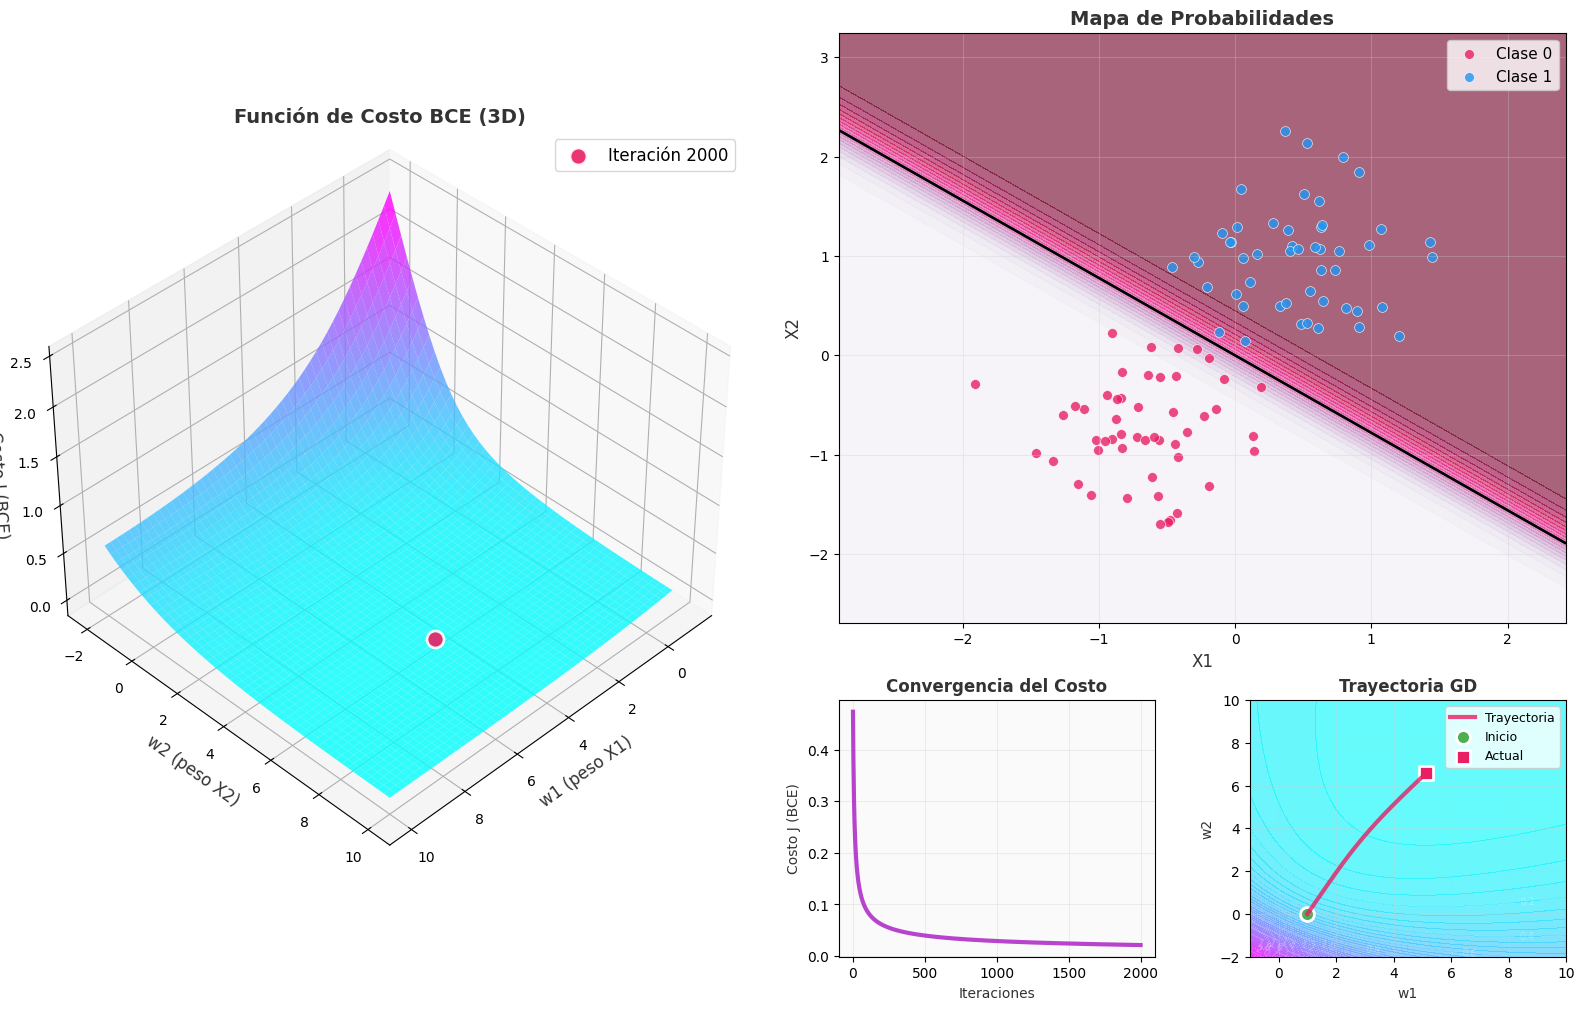

Costo en w1=5.1216, w2=6.5730: 0.0211


In [ ]:
def gradiente_descendente_logistica_visual(X, y, w1_init, w2_init, alpha, iteraciones, mostrar_cada=50):
    """
    Implementa el algoritmo de gradiente descendente para regresión logística con visualización
    X: matriz de características (m x 2)
    y: vector de etiquetas (0 o 1)
    w1_init, w2_init: parámetros iniciales
    alpha: tasa de aprendizaje
    iteraciones: número de iteraciones
    mostrar_cada: cada cuántas iteraciones mostrar la visualización
    """
    m = len(y)
    w1, w2 = w1_init, w2_init
    iteraciones += 1

    historial_costo = []
    historial_w1 = []
    historial_w2 = []

    for i in range(iteraciones):
        h = hipotesis_logistica(X, w1, w2)

        costo = costo_bce(X, y, w1, w2)
        historial_costo.append(costo)
        historial_w1.append(w1)
        historial_w2.append(w2)

        dw1 = (1/m) * np.sum((h - y) * X[:, 0])
        dw2 = (1/m) * np.sum((h - y) * X[:, 1])

        w1 = w1 - alpha * dw1
        w2 = w2 - alpha * dw2

        if i % mostrar_cada == 0:
            visualizar_funcion_costo_logistica(X, y, costo_bce, hipotesis_logistica, w1, w2, historial_costo, historial_w1, historial_w2, f"Iteración {i}")

    return w1, w2, historial_costo, historial_w1, historial_w2

w1_inicial, w2_inicial = 1, 0
alpha = 0.3
iteraciones = 2000
mostrar_cada = 100
w1_final, w2_final, costos, w1_hist, w2_hist = gradiente_descendente_logistica_visual(
    X, y_true, w1_inicial, w2_inicial, alpha, iteraciones, mostrar_cada)

## 4. Análisis de los Resultados del Entrenamiento

Después de ejecutar el algoritmo de gradiente descendente, podemos analizar los resultados obtenidos a través de múltiples visualizaciones que nos permiten entender cómo convergió el algoritmo.

### Interpretación de las Visualizaciones

#### 1. Función de Costo 3D (Panel Izquierdo)
- **Superficie BCE**: Representa todos los posibles valores de costo para diferentes combinaciones de parámetros w1 y w2
- **Punto magenta**: Muestra la posición actual de los parámetros durante el entrenamiento
- **Forma convexa**: A diferencia de MSE, BCE puede tener formas más complejas pero sigue siendo convexa

#### 2. Mapa de Probabilidades (Panel Superior Derecho)
- **Puntos azules**: Clase 0 (etiqueta = 0)
- **Puntos magenta**: Clase 1 (etiqueta = 1)
- **Línea negra**: Frontera de decisión donde $P(y=1|x) = 0.5$
- **Evolución**: Durante el entrenamiento, la línea se ajusta para separar mejor las clases
- **Línea pasa por el origen**: Como no hay intercepto, la frontera siempre pasa por (0,0)

#### 3. Convergencia del Costo (Panel Inferior Izquierdo)
- **Tendencia decreciente**: El costo BCE decrece durante el entrenamiento
- **Estabilización**: El algoritmo converge cuando el costo se estabiliza
- **Interpretación**: El modelo mejora su capacidad de clasificación en cada iteración

#### 4. Trayectoria del Gradiente Descendente (Panel Inferior Derecho)
- **Línea magenta**: Camino seguido por los parámetros w1 y w2 durante la optimización
- **Punto verde**: Posición inicial (w1=0, w2=0)
- **Punto magenta**: Posición actual de los parámetros
- **Contornos**: Líneas de nivel de la función de costo

### Métricas de Éxito
Al final del entrenamiento, el algoritmo logra:
- **Separación clara**: La frontera de decisión separa efectivamente las clases
- **Reducción del costo**: El costo BCE disminuye significativamente
- **Convergencia**: El algoritmo alcanza un punto estable
- **Modelo simplificado**: Funciona correctamente con solo 2 parámetros

### Conclusiones del Proceso
- El gradiente descendente **converge exitosamente** para clasificación binaria con 2 parámetros
- La frontera de decisión **separa correctamente** las clases linealmente separables
- El **mapa de probabilidades** muestra predicciones suaves y coherentes
- La **función sigmoide** mapea correctamente las características al espacio de probabilidades
- El **modelo sin intercepto** es adecuado cuando la frontera pasa por el origen